# Particle Filter 
This file contains the explanation of the Particle Filter algorithm. The main steps are as follows:
1. Initialization --> Creat_uniform_particles function
2. Prediction --> Predict function
3. Update
4. Resampling




In [87]:
# importing standard libraries 
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import uniform , random
from scipy.stats import multivariate_normal
from Robot import Diif_Robot

def create_uniform_particles(x_range,y_range,hdg_range,N):
    """"
    Create particles uniformly distributed in a given range.
    x_range: tuple (min,max) - map width limits
    y_range: tuple (min,max) y - map height limits 
    hdg_range: tuple (min,max) heading range
    N: int
    """
    particles = np.empty((N,3))
    particles[:,1] = uniform(x_range[0],x_range[1],size=N)
    particles[:,0] = uniform(y_range[0],y_range[1],size=N)
    particles[:,2] = uniform(hdg_range[0],hdg_range[1],size=N)
    particles[:,2] %= 2 * np.pi

    return particles

def predict(particles, u, motion_dist, dt):
    """"
    Predict the position of the particles after a movement command.
    particles: 2D numpy array
    u: tuple (v,w) - velocity and angular velocity
    motion_dist: tuple (alpha1,alpha2,alpha3,alpha4) - motion noise parameters
    dt: float - time step
    """
    for i in range(len(particles)):
        Motion = Diif_Robot(0.75,0.3/2,particles[i,1],particles[i,0],particles[i,2])
        particles[i,:] += Motion.motion_model(u,dt) + motion_dist
    return particles

def update(particles, y, w , Q):
    """
    Update the weights of the particles using a measurement.
    particles: 2D numpy array
    y: Robot location (?)
    w: numpy array - weights
    Q: 2D numpy array - measurement noise
    """
    for i in range(len(particles)):
        w[i] = multivariate_normal.pdf(y,mean=particles[i,0:2], cov=Q)
    w += 1.e-300
    w /= sum(w)

    return w

# def update(particles, weights, z, R, landmarks):
#     """"
#     Update the weights of the particles using a measurement.
#     particles: 2D numpy array
#     weights: numpy array
#     z: tuple (range,bearing) - measurement
#     R: 2D numpy array - measurement noise
#     landmarks: 2D numpy array
#     """
#     for i in range(len(particles)):
#         d = np.linalg.norm(landmarks - particles[i,0:2],axis=1)
#         z_hat = (d, np.arctan2(landmarks[:,1] - particles[i,1],landmarks[:,0] - particles[i,0]) - particles[i,2])
#         weights[i] *= multivariate_normal(mean=z_hat,cov=R).pdf(z)
#     weights += 1.e-300
#     weights /= sum(weights)

def simple_resample(particles, weights):
    """
    Resample particles with a simple method.
    particles: 2D numpy array
    weights: numpy array
    """
    N = len(particles)
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1. # avoid round-off error
    indexes = np.searchsorted(cumulative_sum, random(N))
    # resample according to indexes
    particles[:] = particles[indexes]
    weights.fill(1.0 / N)

    return particles

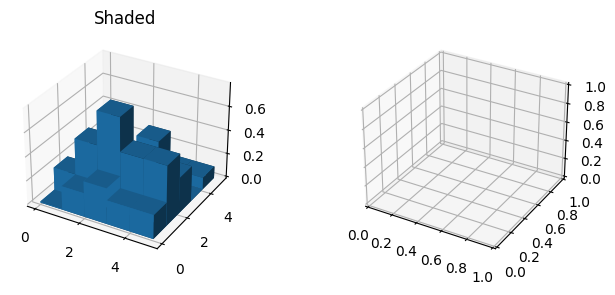

In [88]:
## drawing 3d hsitogram of the measurement model to have a better understanding of the data
# setup the figure and axes
fig = plt.figure(figsize=(8, 3))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# fake data
_x = np.arange(5)
_y = np.arange(5)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()
mymatrix =np.array([0.01,0.2,0.3,0.2,0.2,0.2,0.5,0.78,0.5,0.5,0.1,0.02,0.01,0.1,0.3,0.001,0.001,0.01,0.001,0.001,0.001,0.1,0.3,0.1,0.1])
top = mymatrix
bottom = np.zeros_like(top)
width = depth = 1

ax1.bar3d(x, y, bottom, width, depth, top, shade=True)
ax1.set_title('Shaded')

plt.show()

In [116]:
#calculating var_x, var_y, mean_x, mean_y and cov
measurement_model = np.array([[0.01,0.2,0.3,0.2,0.2],[0.2,0.5,0.78,0.5,0.5],[0.1,0.02,0.01,0.1,0.3],[0.001,0.001,0.01,0.001,0.001],[0.001,0.1,0.3,0.1,0.1]])
xmatrix =np.zeros(5)
ymatrix = np.zeros(5)
x = np.arange(-2,3)
y = np.array([2,1,0,-1,-2])
for i in range(5):
  xmatrix[i] = sum(measurement_model[:,i])
  ymatrix[i] = sum(measurement_model[i,:])
xmean = np.average(x, weights=xmatrix)
ymean = np.average(y, weights=ymatrix)
varx_meas = np.average((x-xmean)**2, weights=xmatrix)
vary_meas = np.average((y-ymean)**2, weights=ymatrix)
covx = 0 
for i in range(5):
  for j in range(5):
    covx += measurement_model[i,j]*(x[j]-xmean)*(y[i]-ymean)
ans = (covx)/sum(xmatrix)

Q = np.array([[varx_meas,ans],[ans,vary_meas]])
mean_distribution_meas = np.array([0,0])
Q = np.array([[0.1,0],[0,0.1]])
delta_meas = np.random.multivariate_normal(mean_distribution_meas , Q)

In [117]:
np.array([[varx_meas,ans],[ans,vary_meas]])

array([[ 1.49235584, -0.03605581],
       [-0.03605581,  1.42023021]])

In [118]:
#The following function is used to plot the actual position of the robot and particles on the map
def creat_plot(particles,state_real,x_lim,y_lim):
  f = plt.figure()
  ax = f.add_subplot(1, 1, 1)
  f.set_figwidth(10)
  f.set_figheight(10)
  plt.plot(particles[:,0],particles[:,1],'o',label='particles')
  plt.plot(state_real[0],state_real[1],'.',label='Real Position of the robot', markersize=30)
  plt.xlim(x_lim[0]*1.2,x_lim[1]*1.2)
  plt.ylim(y_lim[0]*1.2,y_lim[1]*1.2)
  plt.legend(loc='upper right')
  plt.grid()

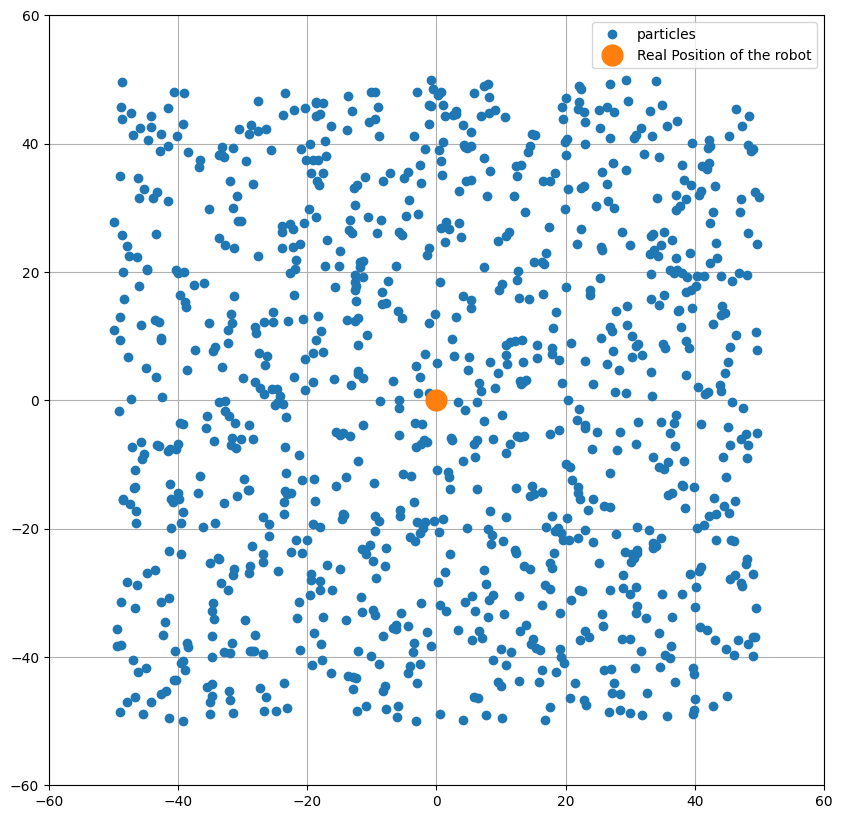

In [119]:
No_Particles = 1000
x_range = (-50,50)
y_range = (-50,50)
hdg_range = (0, np.pi*2)
robot_initial_state = np.array([0.0,0.0,0.0]) # this is the initial real state of the robot
prior_particles = create_uniform_particles(x_range, y_range, hdg_range, No_Particles)
creat_plot(prior_particles,robot_initial_state,x_range,y_range)

In [120]:
## Define robot specification 
u = np.array([3,0])
## Defining epsilon == motion distribution
mean_distribution = np.array([0,0,0])
var_distribution = 0
cov_distribution = 0
R = np.array([[var_distribution,cov_distribution,cov_distribution],[cov_distribution,var_distribution,cov_distribution],[cov_distribution,cov_distribution,var_distribution]])
motion_dist = np.random.multivariate_normal(mean_distribution , R)
#motion_dist = np.random.normal(loc = 0 , scale = 2, size = (3,1))

dt = 0.1 

##
newparticle = prior_particles.copy()
newparticle = predict(newparticle,u,motion_dist,dt)

robot_state = np.array([robot_initial_state.copy()])
robot_state = predict(robot_state,u,motion_dist,dt)


In [121]:
robot_state
for i in range(len(robot_state)):
  print(robot_state[i])

[0.       0.084375 0.      ]


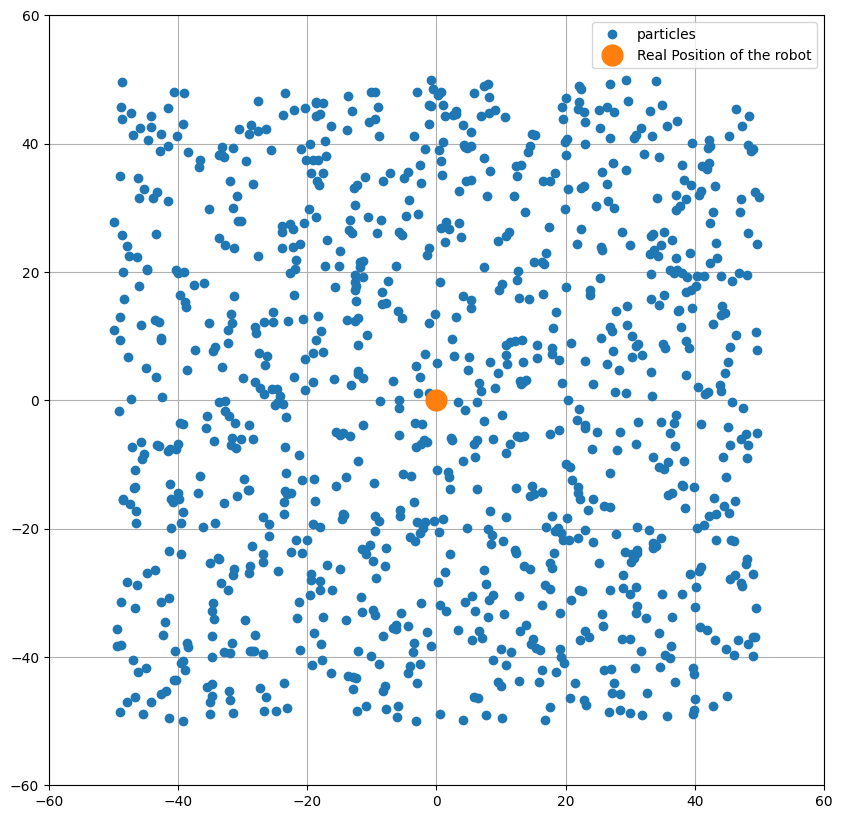

In [122]:
creat_plot(prior_particles,robot_initial_state,x_range,y_range)

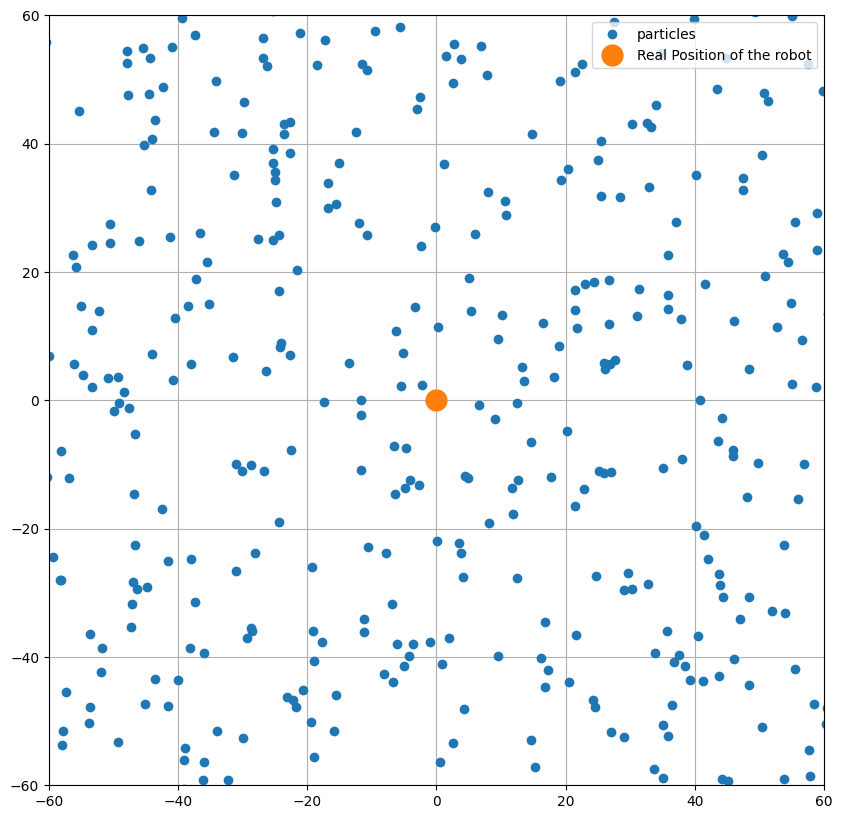

In [123]:
creat_plot(newparticle,robot_state[0],x_range,y_range)

In [124]:
#first time interval
y = robot_state[0,0:2] + delta_meas
w = np.ones(len(newparticle))/No_Particles
w = update(newparticle,y,w,Q)
newparticle =  simple_resample(newparticle, w)
print(np.mean(newparticle[:,0]))
print(np.mean(newparticle[:,1]))
print(np.mean(newparticle[:,2]))
print(robot_state)

-0.24395414193091994
-0.1022872078343495
10.698773222777115
[[0.       0.084375 0.      ]]


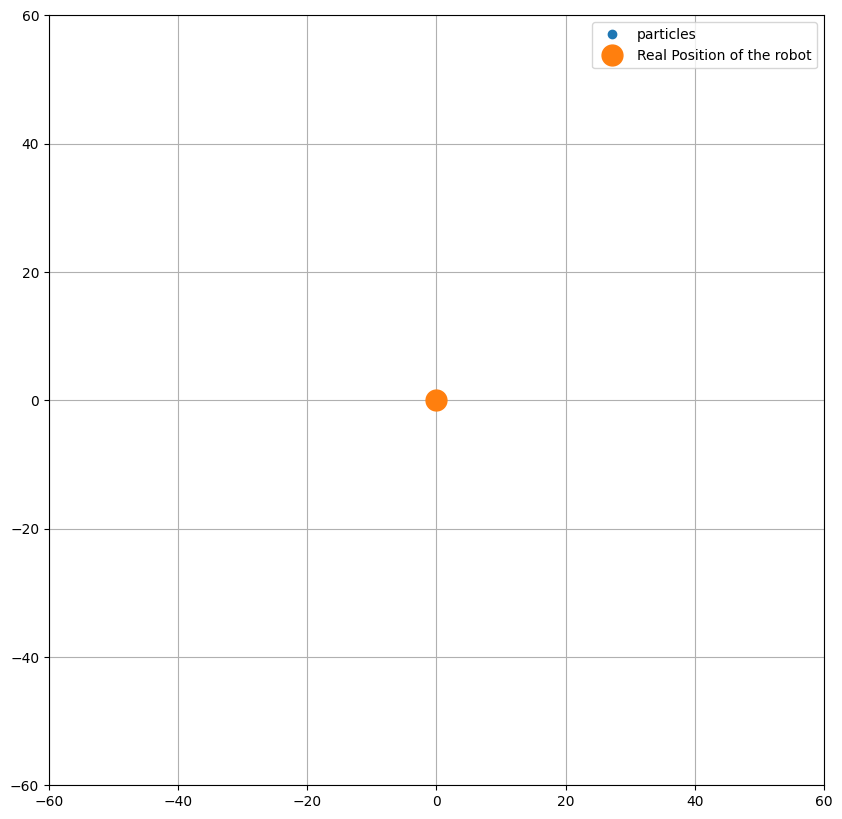

In [125]:
creat_plot(newparticle,robot_state[0],x_range,y_range)

In [126]:
dt = 0.1 

##
newparticle = predict(newparticle,u,motion_dist,dt)
robot_state = predict(robot_state,u,motion_dist,dt)

#first time interval
y = robot_state[0,0:2] + delta_meas
w = np.ones(len(newparticle))/No_Particles
w = update(newparticle,y,w,Q)
newparticle =  simple_resample(newparticle, w)
print(np.mean(newparticle[:,0]))
print(np.mean(newparticle[:,1]))
print(np.mean(newparticle[:,2]))
print(robot_state)

-0.5685941514712126
-0.229250950942574
21.39754644555423
[[0.       0.253125 0.      ]]


In [127]:
print([np.mean(newparticle[:,0]),np.mean(newparticle[:,1]),np.mean(newparticle[:,2])])
print(robot_state)

[-0.5685941514712126, -0.229250950942574, 21.39754644555423]
[[0.       0.253125 0.      ]]


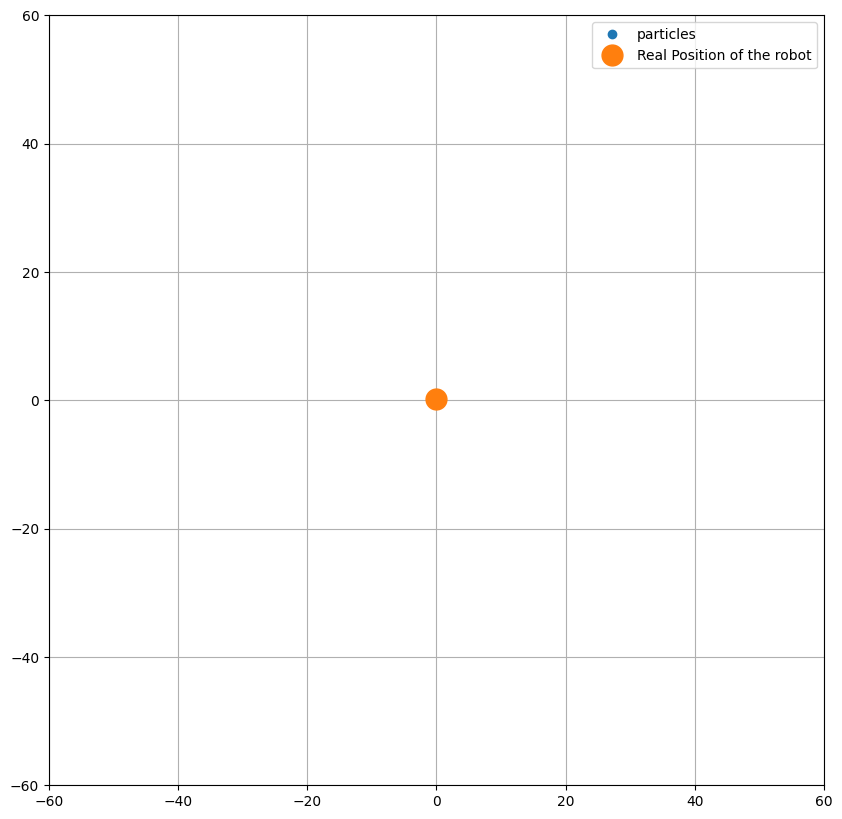

In [128]:
creat_plot(newparticle,robot_state[0],x_range,y_range)

-1.089993099193308
-0.5284429725666815
42.79509289110846
[[0.       0.590625 0.      ]]


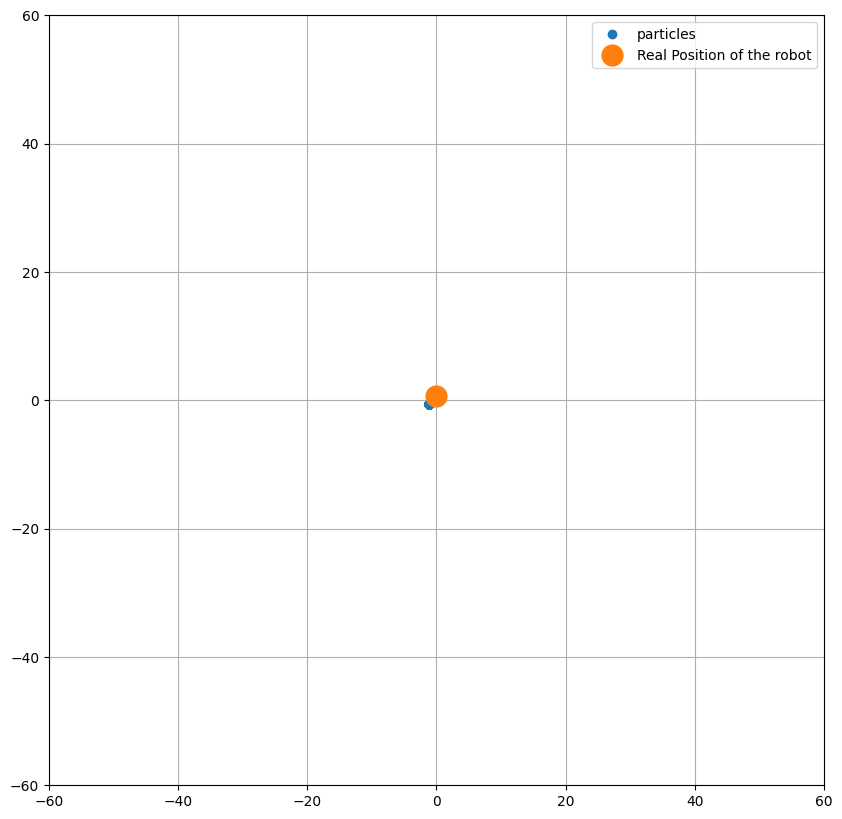

In [129]:
##
newparticle = predict(newparticle,u,motion_dist,dt)
robot_state = predict(robot_state,u,motion_dist,dt)

#first time interval
y = robot_state[0,0:2] + delta_meas
w = np.ones(len(newparticle))/No_Particles
w = update(newparticle,y,w,Q)
newparticle =  simple_resample(newparticle, w)
print(np.mean(newparticle[:,0]))
print(np.mean(newparticle[:,1]))
print(np.mean(newparticle[:,2]))
print(robot_state)

creat_plot(newparticle,robot_state[0],x_range,y_range)

-145.14646853738842
-67.62141281019215
5477.771890061883
[[ 0.       86.315625  0.      ]]


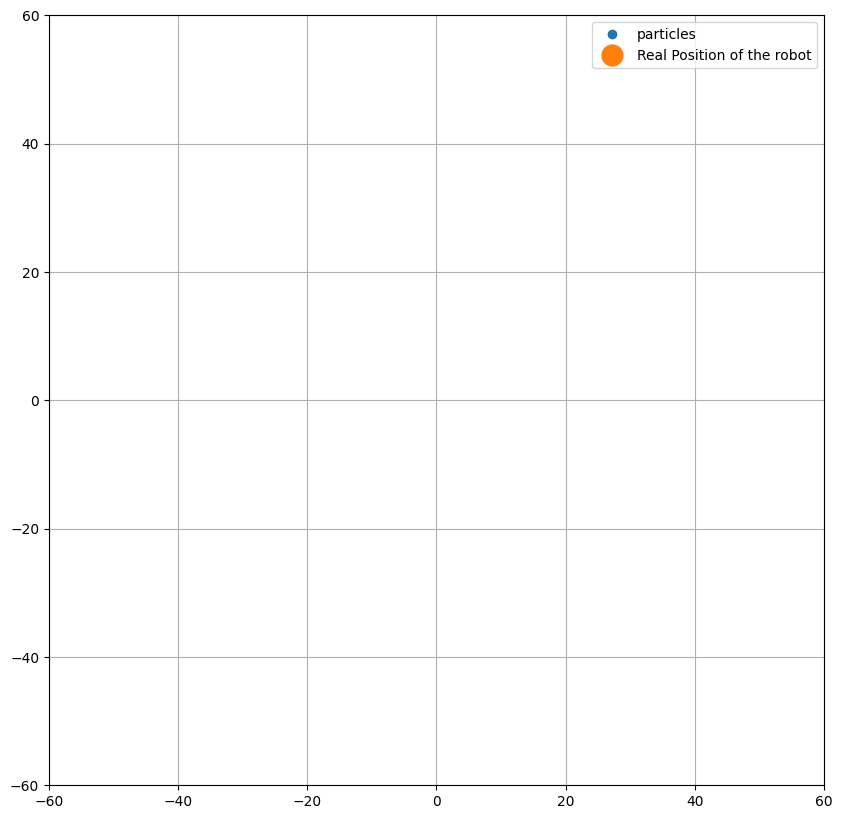

In [136]:
##
newparticle = predict(newparticle,u,motion_dist,dt)
robot_state = predict(robot_state,u,motion_dist,dt)

#first time interval
y = robot_state[0,0:2] + delta_meas
w = np.ones(len(newparticle))/No_Particles
w = update(newparticle,y,w,Q)
newparticle =  simple_resample(newparticle, w)
print(np.mean(newparticle[:,0]))
print(np.mean(newparticle[:,1]))
print(np.mean(newparticle[:,2]))
print(robot_state)

creat_plot(newparticle,robot_state[0],x_range,y_range)